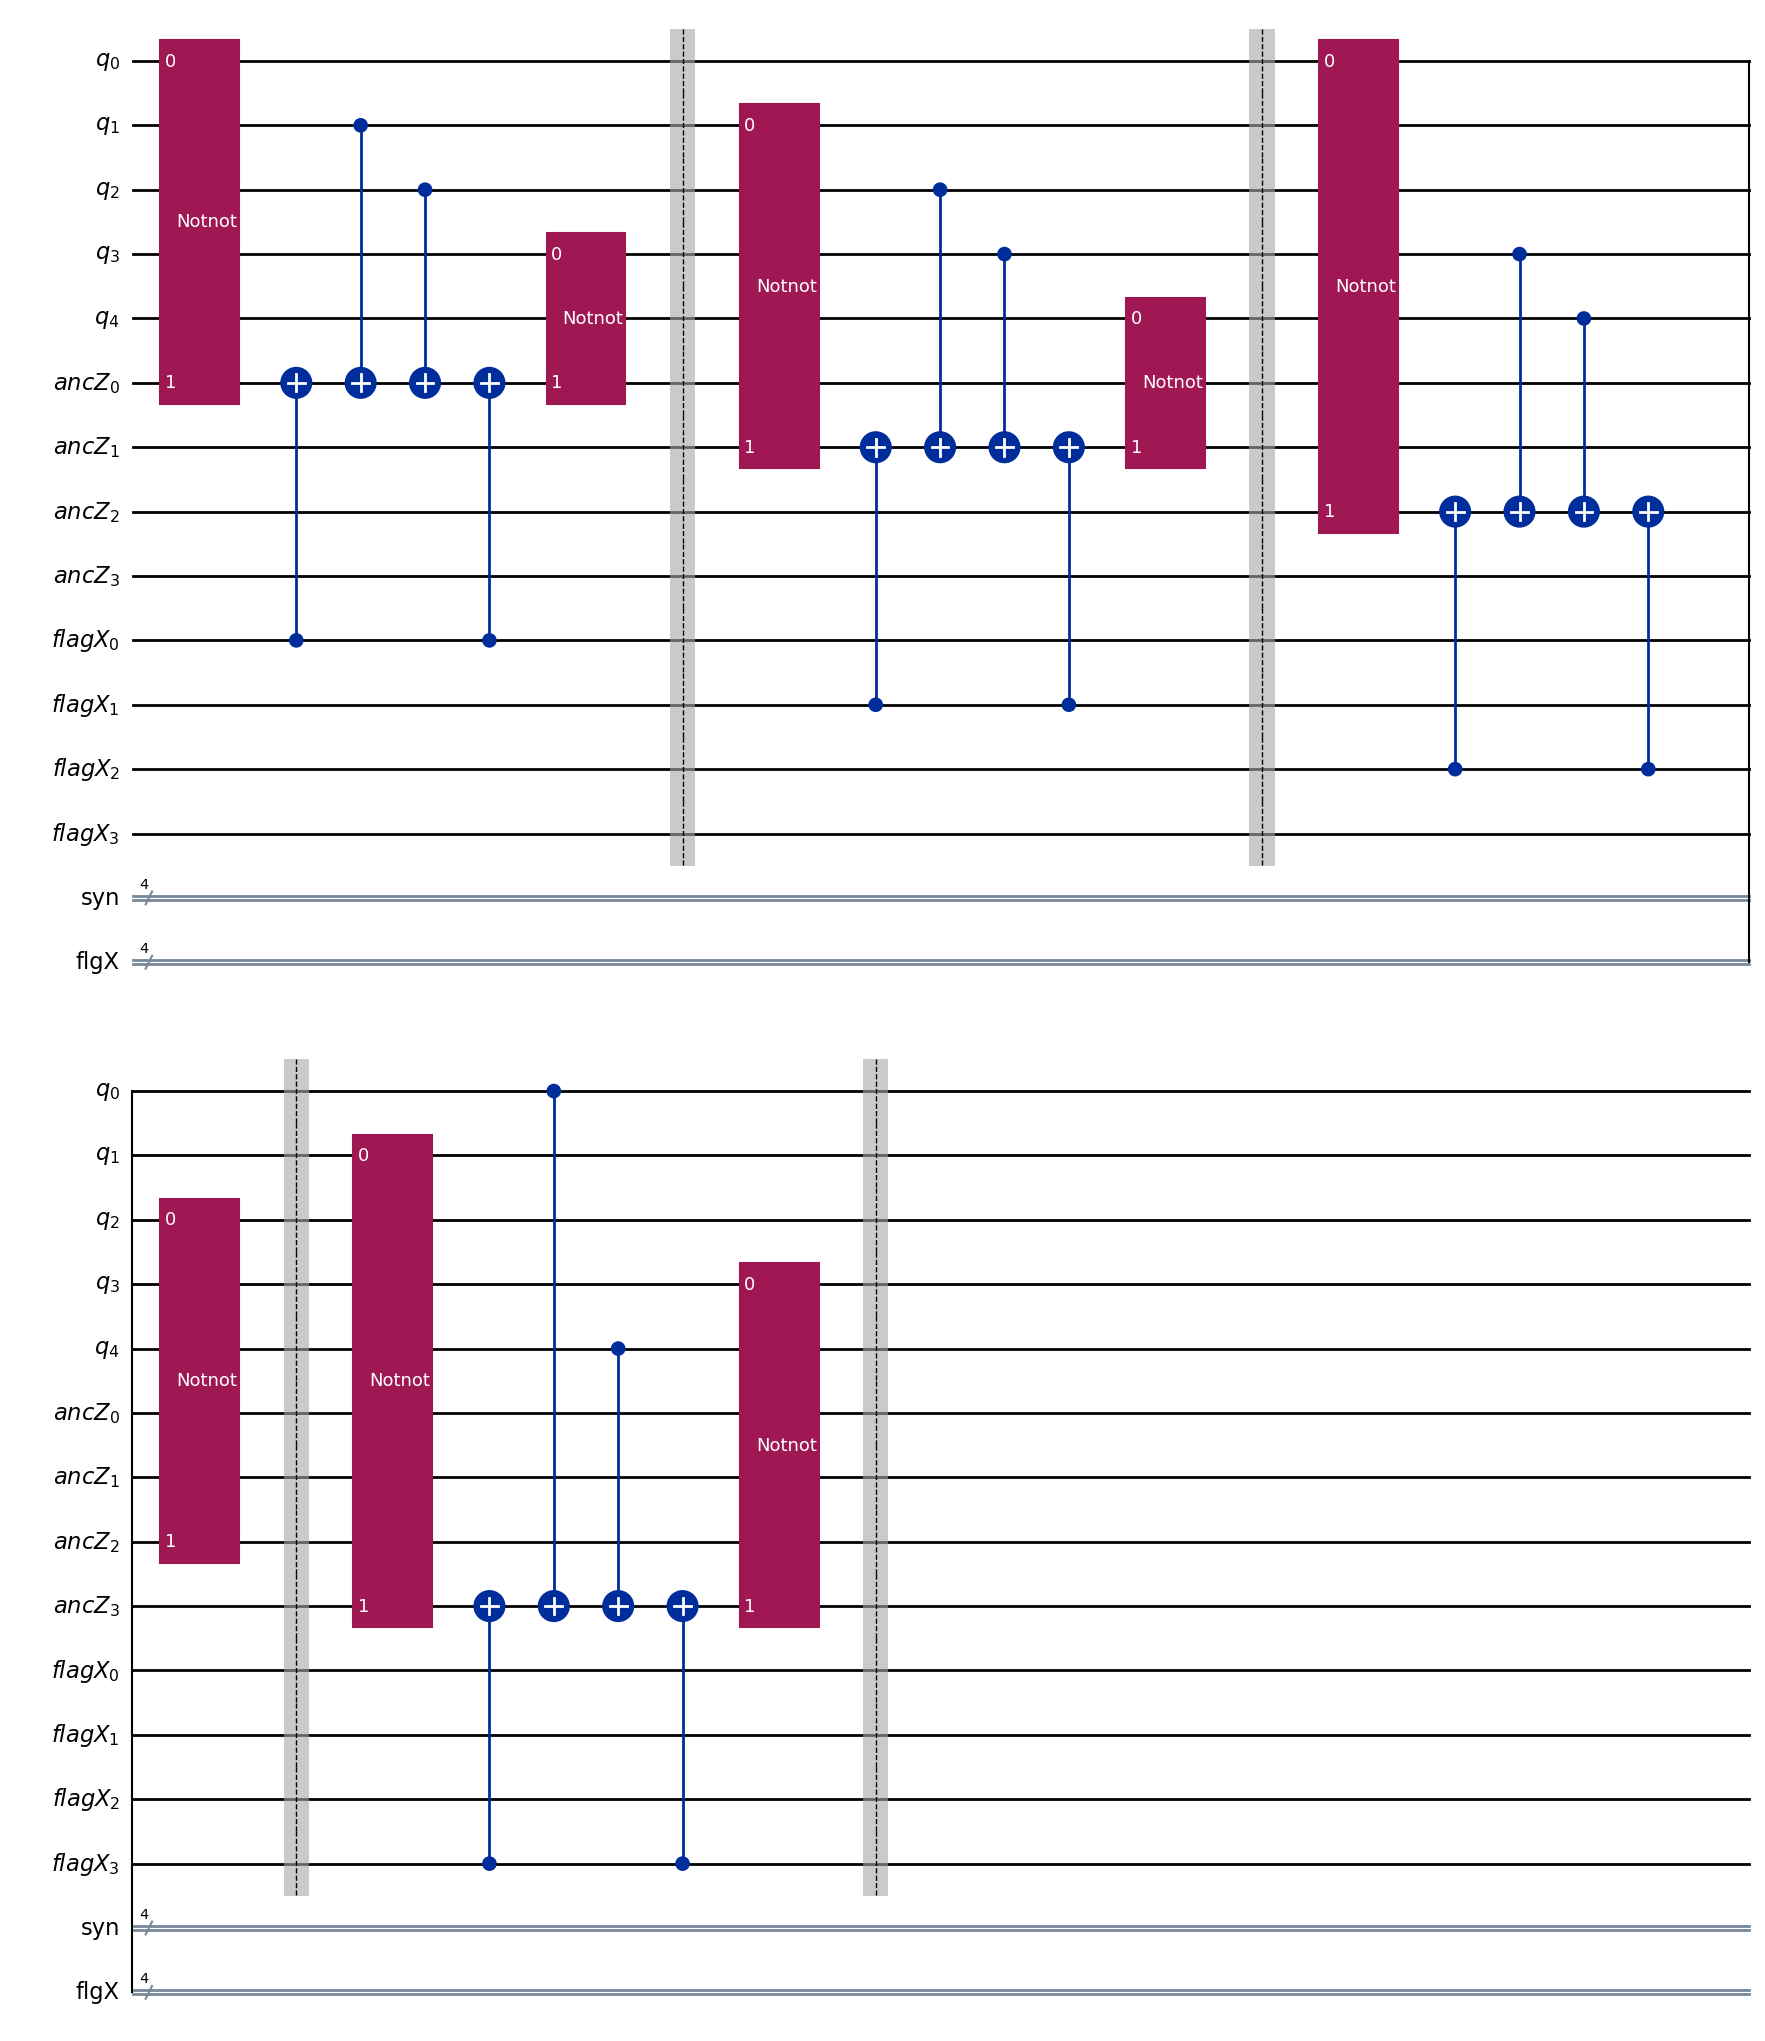

In [12]:
from qiskit import QuantumCircuit
from flag_analysis import *

dir_path = "/Users/wuboris/Desktop/flag verification/[[5,1,3]]_[1,1,1,1]/"
qasm_path = dir_path + "[[5,1,3]]_flag.qasm"
txt_path = dir_path + "[[5,1,3]].txt"
# Load circuit from QASM file
qc = QuantumCircuit.from_qasm_file(qasm_path)

# Draw the circuit (matplotlib drawer)
qc.draw("mpl", filename= dir_path + "[[5,1,3]]_flag.png")

In [13]:
from qiskit import QuantumCircuit

qc = QuantumCircuit.from_qasm_file(qasm_path)
subs =split_circuit_full_q_compact_flags(qc)

# show summary
print(f"Total stabilizers found: {len(subs)}")
for i, sub in enumerate(subs):
    print(f"Subcircuit {i} has {len(sub.data)} gates")

# optionally save them
save_qasm_full_slices(qc, prefix="[[5,1,3]]_flag_stab")

Total stabilizers found: 4
Subcircuit 0 has 7 gates
Subcircuit 1 has 7 gates
Subcircuit 2 has 7 gates
Subcircuit 3 has 7 gates
Saved: [[5,1,3]]_flag_stab_0.qasm
Saved: [[5,1,3]]_flag_stab_1.qasm
Saved: [[5,1,3]]_flag_stab_2.qasm
Saved: [[5,1,3]]_flag_stab_3.qasm


In [14]:
from flag_analysis import *
# Build
state, qc, varenv = build_variable_state_from_qasm(qasm_path)
groups = detect_qubit_groups(qc)

# Flip predicates (basis-aware)
synX_exprs = ancillas_X(state, groups["ancX"])   # X-type syndromes (check .z)
synZ_exprs = ancillas_Z(state, groups["ancZ"])   # Z-type syndromes (check .x)
flgX_exprs = flags_X(state, groups["flagX"])     # flags measured in X (check .z)
flgZ_exprs = flags_Z(state, groups["flagZ"])     # flags measured in Z (check .x)

# Build an assignment:
# - allow arbitrary data errors via named vars (you can set a subset True)
# - force all anc/flag variables to False to model "no circuit faults"
asgmt = {}

# Force all anc/flag vars False:
for name in varenv:
    if name.startswith("ancX") or name.startswith("ancZ") or name.startswith("flagX") or name.startswith("flagZ"):
        asgmt[name] = False

# Example 1: single X error on q[3]  (Steane’s first X-stabilizer should click)

# (all other q*_x/z default to False)

# Evaluate syndromes/flags
synX_vals = [eval_under(e, asgmt, varenv) for e in synX_exprs]
synZ_vals = [eval_under(e, asgmt, varenv) for e in synZ_exprs]
flgX_vals = [eval_under(e, asgmt, varenv) for e in flgX_exprs]
flgZ_vals = [eval_under(e, asgmt, varenv) for e in flgZ_exprs]

print("AncX (X-type) syndromes:", synX_vals)
print("AncZ (Z-type) syndromes:", synZ_vals)
print("Flags X-basis:", flgX_vals)
print("Flags Z-basis:", flgZ_vals)

AncX (X-type) syndromes: []
AncZ (Z-type) syndromes: [Not(((q0_z == q1_x) == q2_x) == q3_z), Not(((q1_z == q2_x) == q3_x) == q4_z), Not(((q0_z == q3_x) == q4_x) == q2_z), Not(((q1_z == q0_x) == q4_x) == q3_z)]
Flags X-basis: [False, False, False, False]
Flags Z-basis: []


In [15]:
# Build circuit state first, to get varenv with q{i}_x/z
state, qc, varenv = build_variable_state_from_qasm(qasm_path)

#print("varenv:", varenv)
# Load stabilizers
stabs = load_symplectic_txt(txt_path)
#print("Stabilizers:", stabs)
# Get Boolean formulas
stab_exprs = [anticomm_formula(Sx, Sz, varenv) for Sx,Sz in stabs]

for i, e in enumerate(stab_exprs):
    print(f"Stabilizer {i} formula:", e)



Stabilizer 0 formula: Xor(Xor(Xor(Xor(False, q0_z), q1_x), q2_x), q3_z)
Stabilizer 1 formula: Xor(Xor(Xor(Xor(False, q1_z), q2_x), q3_x), q4_z)
Stabilizer 2 formula: Xor(Xor(Xor(Xor(False, q0_z), q2_z), q3_x), q4_x)
Stabilizer 3 formula: Xor(Xor(Xor(Xor(False, q0_x), q1_z), q3_z), q4_x)


In [16]:
from flag_analysis import check_ancillas_match_symplectic_ordered

report = check_ancillas_match_symplectic_ordered(
    qasm_path,
    txt_path,
    order="X-then-Z"   # change to "Z-then-X" if your .txt lists Z-first
)

print("OK?", report["ok"])

print("Mismatches:", report["mismatches"])

Overall ordered match: True
OK? True
Mismatches: []


In [17]:
from flag_analysis import *

bad_locations_dict = {}  # Dictionary to store bad locations and gate numbers for each subcircuit
gate_count = 0

for j in range(4):  # Iterate over stabilizers (subcircuits)
    bad_location_in_sub = []
    gate_numbers_in_sub = []  # Store gate numbers for the current subcircuit

    print(f"--- Stabilizer {j} ---")
    for i in range(6):  # Iterate over gates in the subcircuit
        state, qc, site_info, groups = build_state_with_fault_after_gate(
             dir_path + f"/[[5,1,3]]_flag_stab_{j}.qasm",
            gate_index=i,
            fault_mode="2q"
        )
        # Count the number of gates in the subcircuit
        #num_gates = sum(1 for inst in qc.data if inst.operation.name not in ["barrier", "measure"])
        num_gates = sum(1 for inst in qc.data )
        print("Number of gates in this subcircuit:", num_gates)

        # Extract fault variables
        fault_var = [v for k, v in site_info["vars"].items() if k.startswith("f")]

        # Extract qubit groups
        data_idxs = groups["data"]
        ancz_idxs = groups["ancZ"]
        flagx_idxs = groups["flagX"]
        ancx_idxs = groups["ancX"]
        flagz_idxs = groups["flagZ"]

        # Extract error components
        E_x = [state.qubits[i].x for i in data_idxs]
        E_z = [state.qubits[i].z for i in data_idxs]

        # Inject flag errors
        if flagx_idxs:
            flag_var = inject_flag_symbolic_one_axis(state, flagx_idxs[0], axis="z", prefix="flagErr")
        elif flagz_idxs:
            flag_var = inject_flag_symbolic_one_axis(state, flagz_idxs[0], axis="x", prefix="flagErr")

        # Build stabilizer-equivalent errors
        Epx, Epz, gsel = build_stab_equiv_errors(E_x, E_z, txt_path)

        # Build per-qubit error indicators
        b = [Or(xi, zi) for xi, zi in zip(Epx, Epz)]

        # Create a Z3 solver
        from z3 import Solver, Or, PbLe, ForAll, Xor, Implies, Exists
        s = Solver()
        s.add(ForAll(fault_var, Implies(Or(fault_var), Exists(gsel, PbLe([(bi, 1) for bi in b], 1)))))
        #s.add(Xor(site_info["act"], flag_var))

        # Check satisfiability
        print("i ", i, s.check())
        if s.check() == unsat:
            print("Bad location found at gate index:", i)
            bad_location_in_sub.append(i + gate_count)  # Store global gate index
            gate_numbers_in_sub.append(i)  # Store local gate index in the subcircuit

    # Update the gate count for the next subcircuit
    gate_count += num_gates

    # Store bad locations and gate numbers for the current subcircuit
    bad_locations_dict[j] = {
        "bad_locations": bad_location_in_sub,
        "gate_numbers": gate_numbers_in_sub
    }

# Print the results
print("Bad locations dictionary:")
for subcircuit, info in bad_locations_dict.items():
    print(f"Subcircuit {subcircuit}:")
    print(f"  Bad locations (global indices): {info['bad_locations']}")
    print(f"  Gate numbers (local indices): {info['gate_numbers']}")

print(len(bad_locations_dict))

    

--- Stabilizer 0 ---
Number of gates in this subcircuit: 7
i  0 sat
Number of gates in this subcircuit: 7
i  1 sat
Number of gates in this subcircuit: 7
i  2 unsat
Bad location found at gate index: 2
Number of gates in this subcircuit: 7
i  3 unsat
Bad location found at gate index: 3
Number of gates in this subcircuit: 7
i  4 sat
Number of gates in this subcircuit: 7
i  5 sat
--- Stabilizer 1 ---
Number of gates in this subcircuit: 7
i  0 sat
Number of gates in this subcircuit: 7
i  1 sat
Number of gates in this subcircuit: 7
i  2 unsat
Bad location found at gate index: 2
Number of gates in this subcircuit: 7
i  3 unsat
Bad location found at gate index: 3
Number of gates in this subcircuit: 7
i  4 sat
Number of gates in this subcircuit: 7
i  5 sat
--- Stabilizer 2 ---
Number of gates in this subcircuit: 7
i  0 sat
Number of gates in this subcircuit: 7
i  1 sat
Number of gates in this subcircuit: 7
i  2 unsat
Bad location found at gate index: 2
Number of gates in this subcircuit: 7
i  3

In [18]:
###################################
#####check if the flag raised######
###################################
for i in range(len(bad_locations_dict)):  # Iterate over stabilizers (subcircuits)
    
    state, qc, sites_info, groups = build_state_with_faults_after_gates(dir_path +  f"/[[5,1,3]]_flag_stab_{i}.qasm",bad_locations_dict[i]['gate_numbers'], fault_mode="2q")    
    #print(sites_info)

    data_idxs = groups["data"]
    ancz_idxs = groups["ancZ"]
    flagx_idxs = groups["flagX"]
    ancx_idxs = groups["ancX"]
    flagz_idxs = groups["flagZ"]


    fault_var = [[v for k,v in s["vars"].items() if k.startswith("f")] for s in sites_info]
    #print("Injected fault variables:", fault_var)


    all_fault_vars = fault_var[0] + fault_var[1]
    acts = [s["act"] for s in sites_info]
    #print("Active fault sites:", acts)
    #print("Data qubits:", data_idxs)
    #print("Ancilla qubits (Z-basis):", anc_idxs)
    #print("Flag qubits (X-basis):", flag_idxs)

    E_x = [state.qubits[i].x for i in data_idxs]
    E_z = [state.qubits[i].z for i in data_idxs]

    if groups["flagX"] != []: F = [state.qubits[i].z for i in groups["flagX"]]
    elif groups["flagZ"] != []: F = [state.qubits[i].x for i in groups["flagZ"]]
    else: print("No flag qubits found.")


    #print("flag :", F)

    Epx, Epz, gsel = build_stab_equiv_errors(E_x, E_z,txt_path)
    b= [Or(xi, zi) for xi, zi in zip(Epx, Epz)]

    s = Solver()
    # Add the constraint to the solver
    s.add(ForAll(all_fault_vars, Implies(
        And(
            Not(Exists(gsel, PbLe([(bi, 1) for bi in b], 1))),
            Xor(acts[0], acts[1])
        ),
        F[0]  # Combine F_z into a single condition if it's a list
    )))

    print(s.check())


injecting faults after gate 0 notnot
A[0] Xor(False, False)
injecting faults after gate 1 cx
A[0] Xor(Xor(False, False), False)
injecting faults after gate 2 cx
A[0] Xor(Xor(Xor(Xor(False, False), False), False),
    faulty_gate2_x1)
injecting faults after gate 3 cx
A[0] Xor(Xor(Xor(Xor(Xor(Xor(False, False), False), False),
            faulty_gate2_x1),
        False),
    faulty_gate3_x1)
injecting faults after gate 4 cx
A[0] Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, False), False), False),
                faulty_gate2_x1),
            False),
        faulty_gate3_x1),
    False)
injecting faults after gate 5 notnot
A[0] Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, False), False),
                        False),
                    faulty_gate2_x1),
                False),
            faulty_gate3_x1),
        False),
    False)
injecting faults after gate 6 barrier
A[0] Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, False), False),
                        False),
                    faulty_gate2_x1),
  

In [19]:
all_bad_locations = []
for info in bad_locations_dict.values():
    all_bad_locations.extend(info['bad_locations'])

print("All bad locations (global indices):", all_bad_locations)


All bad locations (global indices): [2, 3, 9, 10, 16, 17, 23, 24]


In [20]:
clean_qc = remove_flag_gates(qasm_path, save_path=dir_path + "[[5,1,3]]_no_flag.qasm")
print("Original gates:", len(clean_qc.data))


Original gates: 20


In [21]:
state, qc, sites_info, groups = build_state_with_faults_after_gates( dir_path + f"/[[5,1,3]]_flag.qasm",all_bad_locations, fault_mode="2q")   
#print(sites_info)
data_idxs = groups["data"]
ancz_idxs = groups["ancZ"]
flagx_idxs = groups["flagX"]
ancx_idxs = groups["ancX"]
flagz_idxs = groups["flagZ"]

print("Data qubits:", data_idxs)
print("Ancilla qubits (Z-basis):", ancz_idxs)
print("Ancilla qubits (X-basis):", ancx_idxs)
print("Flag qubits (X-basis):", flagx_idxs)
print("Flag qubits (Z-basis):", flagz_idxs)



fault_var = [[v for k,v in s["vars"].items() if k.startswith("f")] for s in sites_info]
gate_fault_constr = [Or(f) for f in fault_var if f != []]



flag_err_var =  []

flag_err_var.extend(inject_on_flags(state, flagx_idxs, axis="z", prefix="flagErr"))

flag_err_var.extend(inject_on_flags(state, flagz_idxs, axis="x", prefix="flagErr"))

anc_err_var = [] 

anc_err_var.extend(inject_on_flags(state, ancx_idxs, axis="z", prefix="ancErr"))
anc_err_var.extend(inject_on_flags(state, ancz_idxs, axis="x", prefix="ancErr"))

all_fault = gate_fault_constr+ flag_err_var + anc_err_var

one_fault_constr = [PbLe( [(f,1) for f in all_fault], 1)]

after_raw_state = symbolic_propagate_state_checked(dir_path + "/[[5,1,3]]_no_flag.qasm",state)


var = [sub for sub in fault_var for sub in sub] + flag_err_var + anc_err_var

ren_1 = make_renamer_from_symbols(var, "_p1")
ren_2 = make_renamer_from_symbols(var, "_p2")

one_fault_constr_p1 = primed_copy(one_fault_constr, ren_1)
one_fault_constr_p2 = primed_copy(one_fault_constr, ren_2)


A = [state.qubits[i].z for i in ancx_idxs] + [state.qubits[i].x for i in ancz_idxs]
F = [state.qubits[i].z for i in flagx_idxs] + [state.qubits[i].x for i in flagz_idxs]


A_1 = primed_copy(A, ren_1)
A_2 = primed_copy(A, ren_2)
F_1 = primed_copy(F, ren_1)
F_2 = primed_copy(F, ren_2)

after_raw_state = symbolic_propagate_state_checked(dir_path + "/[[5,1,3]]_no_flag.qasm",state)

E_x = [after_raw_state.qubits[i].x for i in data_idxs]
E_z = [after_raw_state.qubits[i].z for i in data_idxs]

raw_A = [after_raw_state.qubits[i].z for i in ancx_idxs] + [after_raw_state.qubits[i].x for i in ancz_idxs]

E_x_1 = primed_copy(E_x, ren_1)
E_z_1 = primed_copy(E_z, ren_1)
E_x_2 = primed_copy(E_x, ren_2)
E_z_2 = primed_copy(E_z, ren_2)

raw_A_1 = primed_copy(raw_A, ren_1)
raw_A_2 = primed_copy(raw_A, ren_2)

gen_syn_1 = A_1 + F_1 + raw_A_1
gen_syn_2 = A_2 + F_2 + raw_A_2

stab_eq , gsel = exists_stab_equiv(E_x_1, E_z_1, E_x_2, E_z_2, txt_path)




same_syn =  And( *[x == y for x, y in zip(gen_syn_1, gen_syn_2)] )

s.add(same_syn, Not(Exists(gsel, stab_eq)))
s.add(one_fault_constr_p1)
s.add(one_fault_constr_p2)


print(s.check()) 


injecting faults after gate 0 notnot
A[0] Xor(False, False)
injecting faults after gate 1 cx
A[0] Xor(Xor(False, False), False)
injecting faults after gate 2 cx
A[0] Xor(Xor(Xor(Xor(False, False), False), False),
    faulty_gate2_x1)
injecting faults after gate 3 cx
A[0] Xor(Xor(Xor(Xor(Xor(Xor(False, False), False), False),
            faulty_gate2_x1),
        False),
    faulty_gate3_x1)
injecting faults after gate 4 cx
A[0] Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, False), False), False),
                faulty_gate2_x1),
            False),
        faulty_gate3_x1),
    False)
injecting faults after gate 5 notnot
A[0] Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, False), False),
                        False),
                    faulty_gate2_x1),
                False),
            faulty_gate3_x1),
        False),
    False)
injecting faults after gate 6 barrier
A[0] Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, False), False),
                        False),
                    faulty_gate2_x1),
  

In [11]:
for d in s.model().decls(): 
    
    val = s.model()[d]
    if str(val)  == "True": 
        print(f"{d.name()} = {val}")


Z3Exception: model is not available

In [23]:



val_1 =  {"faulty_gate2_x0" : True}
val_2 =  { "faulty_gate16_x0" : True }
for i in range(len(A)): 
    print(f"A_{i}", eval_with_values(A[i], val_1),  eval_with_values(A[i], val_2))
for i in range(len(F)): 
    print(f"F_{i}", eval_with_values(F[i], val_1), eval_with_values(F[i], val_2))

for i in range(len(raw_A)): 
    print(f"raw_A_{i}", eval_with_values(raw_A[i], val_1) , eval_with_values(raw_A[i], val_2))

A_0 False False
A_1 False False
A_2 False False
A_3 False False
F_0 False False
F_1 False False
F_2 False False
F_3 False False
raw_A_0 True False
raw_A_1 False True
raw_A_2 False True
raw_A_3 False False


In [16]:

for E in E_x_1:
    val  = eval_with_values(E, val_1)
    print("E_x_1", val)

for E in E_z_1:
    val  = eval_with_values(E, val_1)
    print("E_z_1", val)

for E in E_x_2:
   val  = eval_with_values(E, val_2)
   print("E_x_2", val)

for E in E_z_2:
   val  = eval_with_values(E, val_2)
   print("E_z_2", val)


for A in A_1:
    val  = eval_with_values(A, val_1)
    print("A_1", val)
for F in F_1:
    val  = eval_with_values(F, val_1)
    print("F_1", val)

for A in A_2:
    val  = eval_with_values(A, val_2)
    print("A_2", val)
for F in F_2:
    val  = eval_with_values(F, val_2)
    print("F_2", val)

for raw_A in raw_A_1:
    val  = eval_with_values(raw_A, val_1)
    print("raw_A_1", val)

for raw_A in raw_A_2:
    val  = eval_with_values(raw_A, val_2)
    print("raw_A_2", val)


E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
A_1 False
A_1 False
A_1 False
A_1 False
F_1 False
F_1 False
F_1 False
F_1 False
A_2 False
A_2 False
A_2 False
A_2 False
F_2 False
F_2 False
F_2 False
F_2 False
raw_A_1 False
raw_A_1 False
raw_A_1 False
raw_A_1 False
raw_A_2 False
raw_A_2 False
raw_A_2 False
raw_A_2 False


In [49]:
m =s.model()
for E in E_x_1:
    val  = m.eval(E,model_completion=True)
    print("E_x_1", val)

for E in E_z_1:
    val  = m.eval(E,model_completion=True)
    print("E_z_1", val)

for E in E_x_2:
    val  = m.eval(E,model_completion=True)
    print("E_x_2", val)

for E in E_z_2:
    val  = m.eval(E,model_completion=True)
    print("E_z_2", val)


for A in A_1:
    val  = m.eval(A,model_completion=True)
    print("A_1", val)
for F in F_1:
    val  = m.eval(F,model_completion=True)
    print("F_1", val)

for A in A_2:
    val  = m.eval(A,model_completion=True)
    print("A_2", val)
for F in F_2:
    val  = m.eval(F,model_completion=True)
    print("F_2", val)

for raw_A in raw_A_1:
    val  = m.eval(raw_A,model_completion=True)
    print("raw_A_1", val)

for raw_A in raw_A_2:
    val  = m.eval(raw_A,model_completion=True)
    print("raw_A_2", val)


Z3Exception: model is not available